# Challenge Avanzado: 

Elaboró: Leon Palomares

Fecha: 24/11/2025

Bases de Datos: Encuesta Nacional sobre Uso de Tiempo, INEGI.


In [24]:
# Imports principales
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, when

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PrediccionCalidadVino')\
        .getOrCreate()

In [18]:
df = spark.read.csv('Data/tvar_crea.csv',
                       inferSchema = True,
                       sep=",",
                       header = True)

print(type(df1))

print(df.show(5))
print(df.printSchema())
print('Numero de columnas: ', len(df.columns))

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------+--------+---------+------------------+------------------+------------------+------------+------------------+--------+-------------------+------------------+------------------+------------------+------------------+--------+------------------+-----------+--------------+-------------------+------------------+--------------------+-----------------------+-----------------------+-------------------+-------------------+--------------------+--------------------+--------------+---------------------+---------------------+---------------------+------------+----------------------+-----------------+------------------+------------------+-------------------+--------------------+--------------+------------------+------------------+----+----+---+---+------+-------+----+-------+-----------+--------+---------+--------+-------+-------+-------+-------+-------+-----+-----+
|   LLAVEMOD|LLAVEVIV| LLAVEHOG| ACTIV_PROD_CON_CP| ACTIV_PROD_SIN_CP|        ACT

In [44]:
cols_con_cp = [c for c in df.columns if "CON_CP" in c]
df1 = df.drop(*cols_con_cp)
cols_drop = ["ACTIV_PROD_SIN_CP", "ACTIV_MERC", "LLAVEMOD", "LLAVEVIV", "LLAVEHOG", "PROD_BIEN_HOG_RURAL",
    "PREP_SERV_ALIM_RURAL"]
df1 = df1.drop(*cols_drop)

print("Número total de columnas restantes:", len(df1.columns))

Número total de columnas restantes: 47


In [46]:
sobrecarga = [
    "ACTIV_MERC",
    "TRAB_MERC_PV",
    "TRAS_TRAB",
    "TRAB_NO_REM_HOG",
    "TRAB_NO_REM_CUID_HOG",
    "CUID_ESP_INT_HOG_SIN_CP",
    "CUID_INT_0A5_SIN_CP",
    "CUID_INT_6A14_SIN_CP",
    "CUID_INT_15A59",
    "CUID_INT_60MAS_SIN_CP",
    "TRAB_NO_REM_OTROS_HOG",
    "PROD_BIEN_TRAB_AUTO",
    "PROD_BIEN_HOG_RURAL"
]

sobrecarga = [v for v in sobrecarga if v in df1.columns]

df2 = df1.withColumn(
    "SOBRECARGA",
    sum([col(v) for v in sobrecarga])
)

In [47]:
# Obtener media para binarizar
media_sobrecarga = df2.selectExpr("avg(SOBRECARGA) as mean").collect()[0]["mean"]

# Crear variable binaria
df2 = df2.withColumn(
    "SOBRECARGA_ALTA",
    when(col("SOBRECARGA") > media_sobrecarga, 1).otherwise(0)
)

df2.select("SOBRECARGA", "SOBRECARGA_ALTA").show(20)

+------------------+---------------+
|        SOBRECARGA|SOBRECARGA_ALTA|
+------------------+---------------+
|25.833333333333332|              0|
|30.166666666666664|              0|
| 75.58333333333333|              1|
|18.416666666666668|              0|
|24.083333333333332|              0|
|2.1666666666666665|              0|
| 79.58333333333333|              1|
| 45.91666666666667|              0|
|23.333333333333332|              0|
| 49.18333333333332|              0|
| 73.41666666666666|              1|
|13.816666666666666|              0|
|             74.25|              1|
| 92.18333333333334|              1|
| 95.66666666666667|              1|
|116.81666666666666|              1|
|             81.25|              1|
|              99.0|              1|
| 68.58333333333333|              1|
|100.33333333333334|              1|
+------------------+---------------+
only showing top 20 rows



In [48]:
print(df2.printSchema())

root
 |-- TRAB_MERC_PV: double (nullable = true)
 |-- TRAS_TRAB: double (nullable = true)
 |-- BUS_TRAB: double (nullable = true)
 |-- PROD_BIEN_TRAB_AUTO: double (nullable = true)
 |-- TRAB_NO_REM_VOL: double (nullable = true)
 |-- TRAB_NO_REM_HOG: double (nullable = true)
 |-- PREP_SERV_ALIM: double (nullable = true)
 |-- LIMP_VIV: double (nullable = true)
 |-- LIMP_ROP: double (nullable = true)
 |-- MANT_VIV: double (nullable = true)
 |-- COMPRAS_HOG: double (nullable = true)
 |-- PAGOS_TRAM_HOG: double (nullable = true)
 |-- ORG_SUP_HOG: double (nullable = true)
 |-- TRAB_NO_REM_CUID_HOG: double (nullable = true)
 |-- CUID_ESP_INT_HOG_SIN_CP: double (nullable = true)
 |-- CUID_INT_0A5_SIN_CP: double (nullable = true)
 |-- CUID_INT_6A14_SIN_CP: double (nullable = true)
 |-- CUID_INT_15A59: double (nullable = true)
 |-- CUID_INT_60MAS_SIN_CP: double (nullable = true)
 |-- TRAB_NO_REM_OTROS_HOG: double (nullable = true)
 |-- APOY_HOG_FAM: double (nullable = true)
 |-- TRAB_DOM_OTROS_H

In [66]:
feature_columns = [
    "EDAD", "SEXO", "CVEGEO", "NIV", "TLOC", "COND_AEE"
]

In [67]:
assem = VectorAssembler(inputCols=feature_columns,
                        outputCol='FeatureUnscaled')

df2_vec = assem.transform(df2)

In [68]:
scale = StandardScaler(inputCol="FeatureUnscaled",
                       outputCol="scaledFeatures",
                       withStd=True,
                       withMean=False)

scaler = scale.fit(df2_vec)
df2_scaled = scaler.transform(df2_vec)

In [69]:
train, test = df2_scaled.randomSplit([0.82, 0.18], seed=42)

In [70]:
RL = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="SOBRECARGA_ALTA",
    maxIter=50
)

ModeloRL = RL.fit(train)

In [71]:
predictions = ModeloRL.transform(test)

Evaluador = BinaryClassificationEvaluator(labelCol="SOBRECARGA_ALTA", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
DF_RL = Evaluador.evaluate(predictions)
print(f"Área bajo la curva ROC: {DF_RL:.4f}")

Área bajo la curva ROC: 0.7495


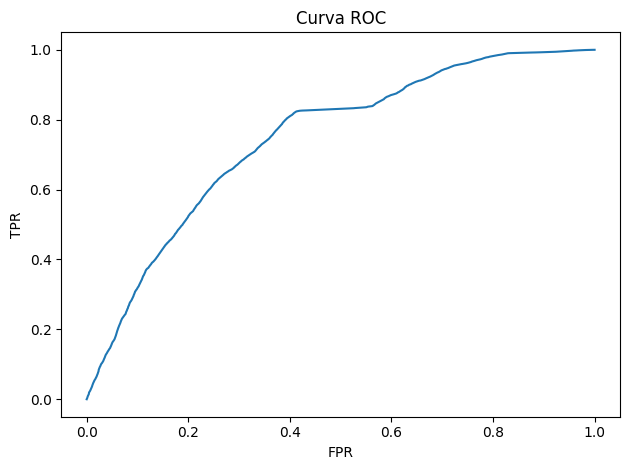

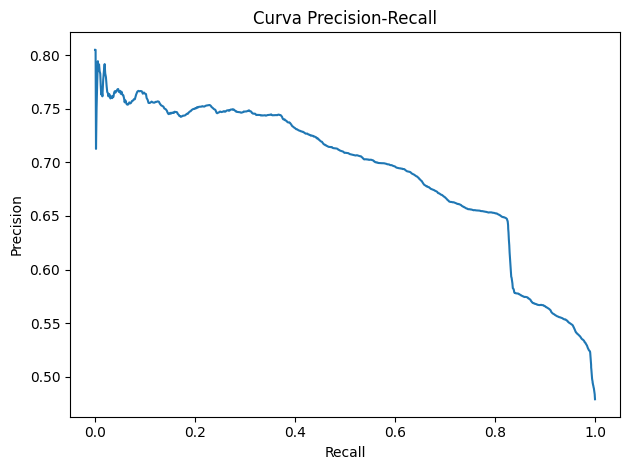

In [72]:
train_summary = ModeloRL.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()

# ROC
plt.figure()
plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.tight_layout()
plt.show()

# PR
plt.figure()
plt.plot(pr_df['recall'], pr_df['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.tight_layout()
plt.show()